In [1]:
import os
import fscope
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import pandas as pd
from scipy.constants import m_e, e
from scipy.optimize import curve_fit
import time
import pickle

def symm_no_hysteresis(R,B,nBins=100):
    """ Calculate the symmetric and asymmetric components of the resistance
    as a function of the magnetic field.
    
    Args:
        R (array): Resistance values
        B (array): Magnetic field values
        nBins (int): Number of bins

    Returns tuple: R_sym, R_asym, B_bin, R_bin
        R_sym (array): Symmetric component of resistance
        R_asym (array): asymmetric component of resistance
        B_bin (array): Magnetic field bin centers
        R_bin (array): Resistance bin centers
    """
    Bmax = np.max(abs(B))
    mean_stat_pos = binned_statistic(B,R,statistic='mean',bins=nBins,range=(-Bmax,Bmax))
    R_bin = mean_stat_pos.statistic
    B_bin = np.array([(a+b)/2 for a,b in zip(mean_stat_pos.bin_edges[:-1],mean_stat_pos.bin_edges[1:])])
    R_sym = (R_bin+np.flip(R_bin))/2
    R_asym = (R_bin - np.flip(R_bin))/2
    return R_sym,R_asym,B_bin,R_bin


def fit(Ts, Rs, Vgs, ns, alpha, relative_effective_mass, RN_cutoff,sample_name="none"):
    """ Fit the data to the full fluctuation conductance model
    
    Args:
        filenames (list): List of filenames
        Vgs (array): List of gate voltages
        ns (array): List of carrier densities
        alpha (float): Alpha parameter
        relative_effective_mass (float): Relative effective mass
        RN_cutoff (float): RN cutoff
    
    Returns dict:
        Dictionary with the fit data
    """
    n_curves = len(Vgs)
    popts=np.zeros((n_curves,3))
    pcovs=np.zeros((n_curves,3,3))
    residuals = np.zeros(n_curves)
    taus=np.zeros(n_curves)
    fits=[]
    T_fits=[]
    R_fits=[]
    for i in range(n_curves):
        print(f"Fitting curve {i+1} of {n_curves} with Vg = {Vgs[i]} V.")
        time0=time.time()

        # Get sorted R(T)
        T=Ts[i]
        R=Rs[i]
        idxsort=np.argsort(T)
        T=T[idxsort]
        R=R[idxsort]

        # First guess of normal resistance
        RN_guess = np.mean(R[-100:])

        # Get the points to fit to the model, limited to 200 to speed up the fitting
        Rtransition=RN_guess*RN_cutoff
        T0 = T[np.argmin(abs(R-Rtransition))]
        T_fit_approx = np.linspace(T0,max(T),200)
        T_fit_idx = [np.argmin(abs(T - T_a)) for T_a in T_fit_approx]
        T_fit = T[T_fit_idx]
        R_fit = R[T_fit_idx]

        # Initial guess for the fit
        p0=[T0-0.002,0.02,RN_guess]
        
        # Get tau from normal resistance
        calc_tau = lambda RN: relative_effective_mass*m_e/(ns[i]*RN*e**2)

        # Fit function with tau linked to RN
        glatz_delta_double_wrapped = lambda x,Tc,delta,RN: fscope.fscope_delta_wrapped_fit(x, Tc, calc_tau(RN), delta, RN)

        # Fit the data
        popt,pcov=curve_fit(glatz_delta_double_wrapped,T_fit,R_fit,p0=p0,bounds=([1.2,0.00001,100],[3,1,RN_guess*2]))
        
        # Get the results
        fit=glatz_delta_double_wrapped(T_fit,*popt)
        taus[i]=calc_tau(popt[2])
        residuals[i]=np.sum((R_fit-fit)**2)/200
        popts[i,:]=popt
        pcovs[i,:,:]=pcov
        fits.append(fit)
        T_fits.append(T_fit)
        R_fits.append(R_fit)

        # Check run time
        fit_time = time.time()-time0
        if fit_time>1200:
            raise Warning(f'Fitting took {int(fit_time/60)} minutes for one curve.')

    fit_data = {
        'alpha':alpha,
        'relative_effective_mass':relative_effective_mass,
        'RN_cutoff':RN_cutoff,
        'Vgs':Vgs,
        'ns':ns,
        'popts':popts,
        'pcovs':pcovs,
        'residuals':residuals,
        'taus':taus,
        'fits':fits,
        'T_fits':T_fits,
        'R_fits':R_fits,
        'Ts':Ts,
        'Rs':Rs,
        'sample_name':sample_name,
    }
    
    return fit_data

# Select which dataset

Run one of the cells below to pick a dataset to fit

### KT010 110 or 112

In [2]:
# Uncomment as needed:
folder = "Data\\KT010\\RTvsGate_110_extended\\"
folder = "Data\\KT010\\RTvsGate_112_extended\\"

# Find carrier density vs backgate

fig,axs=plt.subplots(1,2,figsize=(10,3))

# Ulderico gave me these numbers
Vg_n=[-170, 40, 100, 150]  # last point extrapolated
n=[6.63688286e+17, 7.16125384e+17, 7.18394714e+17, 7.202858223e+17] # last point extrapolated
axs[0].plot(Vg_n[:-1],[y*1e-4 for y in n[:-1]],'C0o-')
axs[0].plot(Vg_n[-2:],[y*1e-4 for y in n[-2:]],'C0--')
axs[0].set_xlabel("$V_G$ (V)")
axs[0].set_ylabel("$n$ (cm$^{-2}$)")

# Get R(T), Vg and n for all the curves to fit
filenames=os.listdir(folder)
Vgs=[float(f.split("_")[-1][:-5]) for f in filenames]
idxsort=np.argsort(Vgs)
Vgs=np.array(Vgs)[idxsort]
filenames=np.array(filenames)[idxsort]
Ts=[]
Rs=[]
Vgs=[]
n_interps=[]
for i,filename in enumerate(filenames):
    data=pd.read_csv(folder+filename,skiprows=[0,2,3],delimiter='\t')
    Vg = float(filename.split("_")[-1][:-5])
    Ts.append(np.array(data[' T (K)'])[9:])
    Rs.append(np.array(data[' X1 (Ohm)'])[9:])
    Vgs.append(Vg)
    n_interps.append(np.interp(Vg,Vg_n,n))
    axs[1].plot(Ts[-1],Rs[-1],color=plt.cm.rainbow(i/len(filenames)))
axs[1].set_xlabel("$T$ (K)")
axs[1].set_ylabel("$R$ ($\\Omega$)")
sample_name = f"KT010_{folder.split('_')[-2]}"
print(sample_name)

### KT027

In [ ]:
# Find carrier density vs backgate

fig,axs=plt.subplots(1,2,figsize=(10,3))

folder = "Data\\KT027\\MR_Rxy\\"
filenames=os.listdir(folder)
Vgs=[float(f.split("_")[-1][:-5]) for f in filenames]
idxsort=np.argsort(Vgs)
filenames=np.array(filenames)[idxsort]
Vg_n=[]
n=[]
for filename in filenames:
    if "-1.0V" not in filename:
        data = pd.read_csv(folder+filename,skiprows=[0,2,3],delimiter='\t')
        R_sym,R_asym,B_bin,R_bin = symm_no_hysteresis(data[" X2 (Ohm)"],data["B (T)"],100)
        m,c=np.polyfit(B_bin,R_asym,1)
        Vg=float(filename.split("_")[-1][:-5])
        Vg_n.append(Vg)
        n.append(-1/(1.60217662e-19*m))
axs[0].plot(Vg_n,[1e-4*a for a in n],'o-')
m,c=np.polyfit(Vg_n[:3],n[:3],1)
Vg_n = [-2]+Vg_n
n = [-2*m+c]+n
n=np.array(n)
Vg_n=np.array(Vg_n)
x=np.array([-2,0.5])
axs[0].plot(x,1e-4*np.polyval([m,c],x),'C0--')
axs[0].set_xlabel("Vg (V)")
axs[0].set_ylabel("n (cm$^{-2}$)")

# Get R(T), Vg and n for all the curves to fit

folder = "Data\\KT027\\RT_gate\\"

filenames=os.listdir(folder)
Vgs=[float(f.split("_")[-1][:-5]) for f in filenames]
idxsort=np.argsort(Vgs)
Vgs=np.array(Vgs)[idxsort]
filenames=np.array(filenames)[idxsort]
Ts=[]
Rs=[]
Vgs=[]
n_interps=[]
for i,filename in enumerate(filenames):
    data=pd.read_csv(folder+filename,skiprows=[0,2,3],delimiter='\t')
    Vg = float(filename.split("_")[-1][:-5])
    Ts.append(np.array(data[' T (K)'])[3:])
    Rs.append(np.array(data[' X2 (Ohm)'])[3:])
    Vgs.append(Vg)
    n_interps.append(np.interp(Vg,Vg_n,n))
    axs[1].plot(Ts[-1],Rs[-1],color=plt.cm.rainbow(i/len(filenames)))
axs[1].set_xlabel("$T$ (K)")
axs[1].set_ylabel("$R$ ($\\Omega$)")
sample_name = f"KT027"
print(sample_name)

## KT030

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(10,3))

folder = "Data\\KT030\\RH Vg step 2\\"
filenames=os.listdir(folder)
Vg_n=[]
n=[]

for filename in filenames:
    data = pd.read_csv(folder+filename,delimiter='\t')
    Vg_n.append(data["A_Vg [V]"][1])
    m,c=np.polyfit(data["B [T]"][1:],data["A_R [ohm]"][1:],1)
    n.append(1/(1.60217662e-19*m))
axs[0].plot(Vg_n,n,'o')
m,c=np.polyfit(Vg_n[:4],n[:4],1)
Vg_n = [-200]+Vg_n # extrapolate to -200
n = [-200*m+c]+n # extrapolate to -200
axs[0].plot(Vg_n,n,'C0')

def remove_bad_T(data,threshold_K=0.06):
    rows_to_delete=abs(data["T [K]"]-data["T [K].1"])>threshold_K
    T = np.array(data["T [K]"])
    T = np.pad(T,1,'edge')
    dT = np.min([abs(T[:-2]-T[1:-1]),abs(T[2:]-T[1:-1])],axis=0)
    rows_to_delete = dT>threshold_K
    data.drop(data[rows_to_delete].index,axis=0,inplace=True)
    data["T_avg [K]"]=(data["T [K]"]+data["T [K].1"])/2
    data["T_err [K]"]=abs(data["T [K]"]-data["T [K].1"])/2

folder = "Data\\KT030\\RT Vg step 2\\"
filenames=os.listdir(folder)
Ts=[]
Rs=[]
Vgs=[]
n_interps=[]
for i,filename in enumerate(filenames):
    data = pd.read_csv(folder+filename,delimiter='\t')
    Vg = data["A_Vg [V]"].iloc[1]
    remove_bad_T(data)
    T=np.array(data["T_avg [K]"])
    R=np.array(data["A_R [ohm]"])/4
    T,R = zip(*sorted(zip(T[1:],R[1:])))
    idx=np.argmin(T)
    axs[1].plot(T[idx:],R[idx:])
    
    Ts.append(np.flip(np.array(T[idx:])))
    Rs.append(np.flip(np.array(R[idx:])))
    Vgs.append(Vg)
    n_interps.append(np.interp(Vg,Vg_n,n))
axs[1].set_xlabel("$T$ (K)")
axs[1].set_ylabel("$R$ ($\\Omega$)")
sample_name = f"KT030"

# Fit the data

In [ ]:
alpha = -1
relative_effective_mass = 0.3
RN_cutoff = 0.25

### Run the fit
fit_data = fit(Ts,Rs,Vgs,n_interps,alpha,relative_effective_mass,RN_cutoff,sample_name=sample_name)

In [ ]:
# pickle the fit data
with open(f"Fit Data/fit_data_{sample_name}.pkl",'wb') as f:
    pickle.dump(fit_data,f)

# Plot the fit

In [ ]:
# Unpickle the fit data
with open(f"Fit Data/fit_data_KT010_112.pkl",'rb') as f:
    fit_data = pickle.load(f)

fig, ax = plt.subplots(figsize=(8,4))
Vgs=fit_data['Vgs']
Vg_min=min(Vgs)
Vg_max=max(Vgs)
n_fits=len(Vgs)
for i in range(n_fits):
    color=plt.cm.rainbow((Vgs[i]-Vg_min)/(Vg_max-Vg_min))
    ax.plot(fit_data['Ts'][i],fit_data['Rs'][i],color=color,label=f"$V_G = {fit_data['Vgs'][i]}$ V")
    ax.plot(fit_data['T_fits'][i],fit_data['fits'][i],'k')
ax.set_xlabel("$T$ (K)")
ax.set_ylabel("$R$ ($\\Omega$)")
ax.set_title(f"Sample {fit_data['sample_name']}")
# create a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=Vg_min, vmax=Vg_max))
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label("$V_G$ (V)")


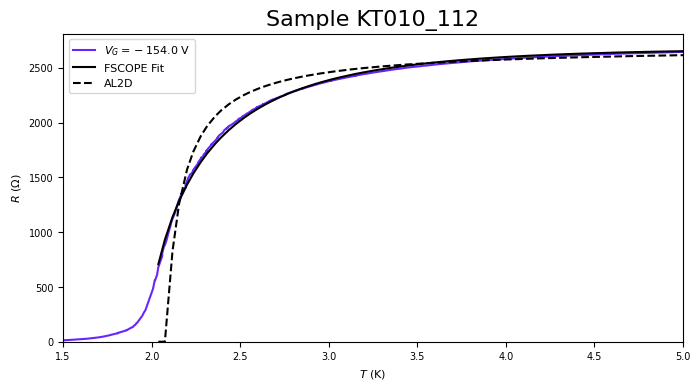

In [6]:
# Choose a curve to plot
i=1

# Unpickle the data
with open(f"Fit Data/fit_data_KT010_112.pkl",'rb') as f:
    fit_data = pickle.load(f)

fig, ax = plt.subplots(figsize=(8,4))
Vgs=fit_data['Vgs']
Vg_min=min(Vgs)
Vg_max=max(Vgs)
n_fits=len(Vgs)

# Plot the data
color=plt.cm.rainbow((Vgs[i]-Vg_min)/(Vg_max-Vg_min))
ax.plot(fit_data['Ts'][i],fit_data['Rs'][i],color=color,label=f"$V_G = {fit_data['Vgs'][i]}$ V")

# Plot the FSCOPE fit
ax.plot(fit_data['T_fits'][i],fit_data['fits'][i],'k',label="FSCOPE Fit")

# Fit AL2D to data and plot
Tc = fit_data['popts'][i][0]
R0 = fit_data['popts'][i][2]
popt,pcov=curve_fit(fscope.AL2D,fit_data['T_fits'][i],fit_data['R_fits'][i],p0=[Tc,R0])
ax.plot(fit_data['T_fits'][i],fscope.AL2D(fit_data['T_fits'][i],*popt),'k--',label="AL2D")
ax.set_xlabel("$T$ (K)")
ax.set_ylabel("$R$ ($\\Omega$)")
ax.set_title(f"Sample {fit_data['sample_name']}")
ax.set_xlim(1.5,5)
ax.set_ylim(0,max(fit_data["Rs"][i]*1.05))
ax.legend()


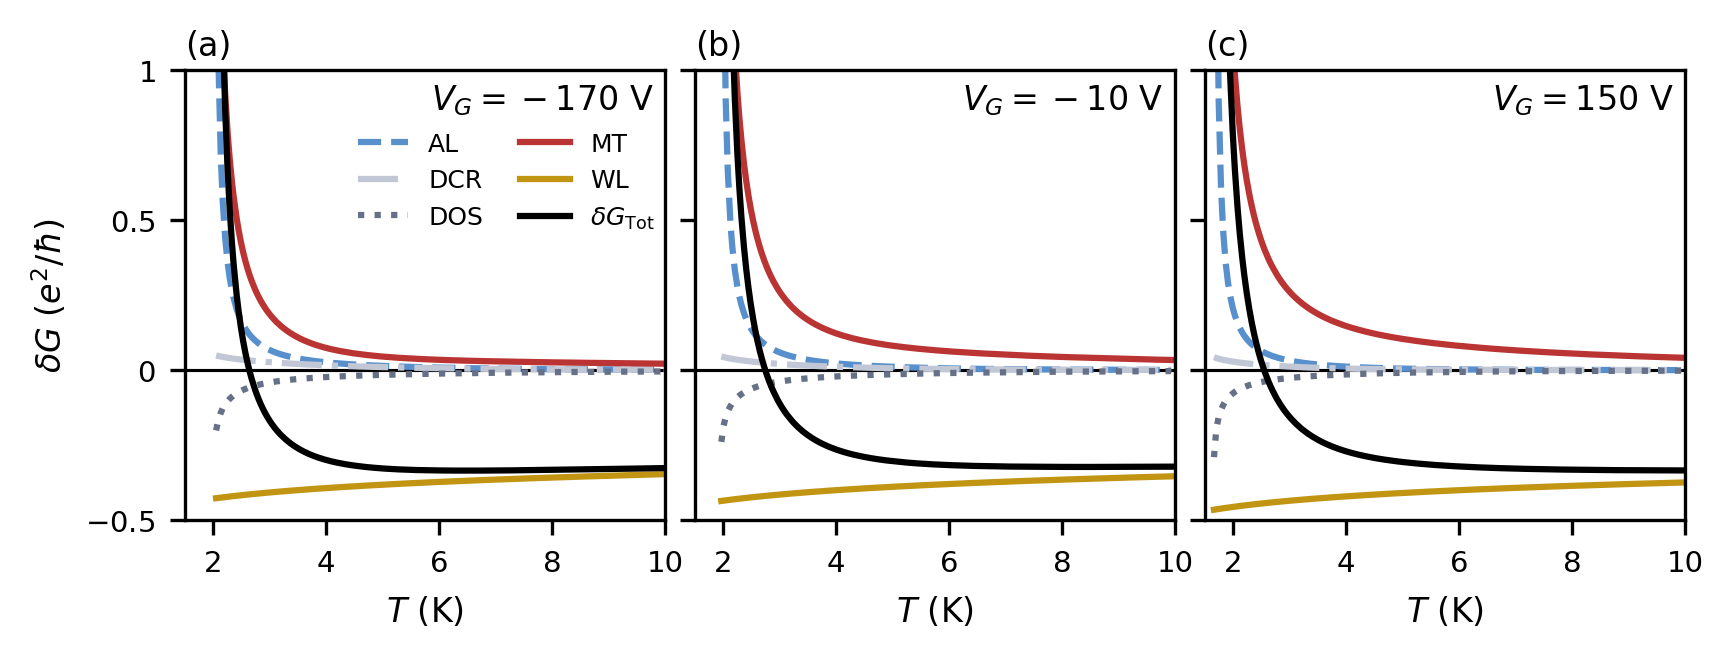

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.facecolor'] = 'white'
plt.style.use('figurestyle.mplstyle')
greys=['#e2e2ea','#c2c7d5','#8f99ac','#667087','#424c63','#232c3e']
blues=['#c5e4fa','#98c5eb','#5890cd','#2368ab','#164688','#092753']
reds=['#f5c9c6','#e49a9c','#d15c59','#ba3433','#8b211f','#651712']
yellows=['#fdefb8','#f2d779','#e4c03a','#c19511','#8e6b09','#5e4a0c']

e=1.60217662e-19 #C
hbar=1.0545718e-34 #Js
conversion = e**2/hbar

fig=plt.figure(figsize=(5,1.5),dpi=300)
w=0.32
g=(1-3*w)/2
axs = [
    fig.add_axes([0,0,w,1]),
    fig.add_axes([w+g,0,w,1]),
    fig.add_axes([2*(w+g),0,w,1]),
]

# Unpickle the data
with open(f"Fit Data//fit_data_KT010_112.pkl",'rb') as f:
    fit_data = pickle.load(f)
Vgs=fit_data['Vgs']
label=["(a)","(b)","(c)"]
for i,v in enumerate([0,10,20]):
    Ts = fit_data['T_fits'][v]
    R, result = fscope.fscope_delta_wrapped(Ts,fit_data['popts'][v][0],fit_data['taus'][v],fit_data['popts'][v][1],fit_data['popts'][v][2])
    axs[i].axhline(0,color='k',linewidth=0.75)
    axs[i].plot(Ts,result["AL"]/conversion,'--',label="AL",color=blues[2])
    axs[i].plot(Ts,result["DCR"]/conversion,'-.',label="DCR",color=greys[1])
    axs[i].plot(Ts,result["DOS"]/conversion,':',label="DOS",color=greys[3])
    axs[i].plot(Ts,result["MT"]/conversion,label="MT",color=reds[3])
    axs[i].plot(Ts,result["WL"]/conversion,label="WL",color=yellows[3])
    axs[i].plot(Ts,result["Total"]/conversion,color='k',label="$\\delta G_\\mathrm{Tot}$")
    axs[i].set_ylim(-0.5,1)
    axs[i].set_xlabel("$T$ (K)")
    axs[i].text(9.8,0.87,f"$V_G={int(Vgs[v])}$ V",ha='right',fontsize=8)
    axs[i].text(1.5,1.05,label[i],ha='left',fontsize=8)
    axs[i].set_yticks([-0.5,0,0.5,1])
    axs[i].set_yticklabels([])
    axs[i].set_xlim(1.5,10)
axs[0].set_yticks([-0.5,0,0.5,1])
axs[0].set_yticklabels(["$-0.5$","$0$","$0.5$","$1$"])
axs[0].set_ylabel("$\\delta G$ ($e^2/\\hbar$)")
axs[0].legend(fontsize=6,ncols=2,columnspacing=1.5,frameon=False,loc=(0.34,0.62))

fig.savefig("Figures//KT010_112_conductivity-components.pdf",bbox_inches='tight')